# Introduction

This notebook implements the AWD-LSTM architecture from [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182#:~:text=Regularizing%20and%20Optimizing%20LSTM%20Language%20Models%20Stephen%20Merity%2C,including%20machine%20translation%2C%20language%20modeling%2C%20and%20question%20answering.) by Merity et al. <br/>
Also, here we implement some of the regularization techniques suggested in the same paper. <br/>
The code is adapted from the original, which can be found on [this](https://github.com/salesforce/awd-lstm-lm) GitHub repo. <br/>
Differently from the original, here we chose a strongly object-oriented approach, <br/>
which we hope will also be helpful for clarifying some otherwise poorly readable lines of code.

# Python Version

In [1]:
!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 2
!python --version

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/

# Import Libraries

In [2]:
import os
import json
import math
import torch
import numpy as np
import torch.cuda as cuda
import torch.nn.functional as F

from tqdm import tqdm
from collections import Counter
from collections.abc import Iterable

from torch import Tensor, LongTensor
from torch.autograd import Variable
from torch.optim import Optimizer, SGD, ASGD
from torch.nn.utils import clip_grad_norm_

from torch.nn import LSTM
from torch.nn import Parameter
from torch.nn import CrossEntropyLoss
from torch.nn import Embedding, Linear, Dropout
from torch.nn import Module, ModuleList

# Device Settings

Ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

CPU vs GPU

In [4]:
seed = 42 # Set manually for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)
if cuda.is_available():
    print('You\'re running on GPU')
    cuda.manual_seed(seed)
    gpu = True
else:
    print('You\'re running on CPU')
    gpu = False

You're running on GPU


Hardware specifications:

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 20 14:28:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
ram_gb = round(ram_gb, 2)
print(f'{ram_gb} GB of RAM\n')

13.62 GB of RAM



Paths and other settings:

In [7]:
MODEL_BASE_DIR = 'data/model'
DATA_BASE_DIR = 'data/penn-treebank'
DATASET = 'ptb'
FORMAT = 'txt'

If executed in Google Colab, import files and change paths:

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
if not os.path.exists('/content/data'):
    os.mkdir('/content/data')
    os.mkdir('/content/data/model')
    os.mkdir('/content/data/penn-treebank')
!cp '/content/drive/My Drive/data/penn-treebank/ptb.train.txt' '/content/data/penn-treebank'
!cp '/content/drive/My Drive/data/penn-treebank/ptb.valid.txt' '/content/data/penn-treebank'
!cp '/content/drive/My Drive/data/penn-treebank/ptb.test.txt' '/content/data/penn-treebank'
drive.flush_and_unmount()

Mounted at /content/drive


# Hyperparams

In [9]:
# General
n_epochs = 100
train_batch_size = 40
val_batch_size = 10
test_batch_size = 1

# Model
word_embed_size = 400
n_hidden_per_layer = 1150
tie_weights = True
n_layers = 3

# Dropout
dropout_input = 0.4
dropout_hidden = 0.3
dropout_layer = 0.4
dropout_embed = 0.1
dropout_weight = 0.5

# Optimizer
weight_decay = 1.2e-6
learning_rate = 30

# Trainer
bptt_seq_len = 70
nt_asgd = 5
grad_clipping = 0.25
patience = 10
lr_reduction_epochs = [] # [5]
lr_reduction_factor = 1 # 10

# Load Data

Define dictionary and corpus classes:

In [10]:
class Dictionary(object):
    def __init__(self):
        self._word2idx = {}
        self._idx2word = []
        self.counter = Counter()
        self.total = 0

    def add_word(self, word: str):
        if word not in self._word2idx:
            self._idx2word.append(word)
            self._word2idx[word] = len(self._idx2word) - 1
        token_id = self._word2idx[word]
        self.counter[token_id] += 1
        self.total += 1
        return self._word2idx[word]

    def word2idx(self, word: str) -> int:
        return self._word2idx[word]
    
    def idx2word(self, idx: int) -> str:
        return self._idx2word[idx]

    def __len__(self):
        return len(self._idx2word)


class Corpus(object):
    def __init__(self, dir: str, dataset: str, format: str, gpu: bool):
        self.gpu = gpu
        self.dictionary = Dictionary()
        self.train = self.tokenize(f'{dir}/{dataset}.train.{format}')
        self.valid = self.tokenize(f'{dir}/{dataset}.valid.{format}')
        self.test = self.tokenize(f'{dir}/{dataset}.test.{format}')

    def tokenize(self, path: str) -> LongTensor:
        if not os.path.exists(path):
            raise ValueError(f'Invalid path=[{path}]')
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)
        # Tokenize file content
        with open(path, 'r') as f:
            ids = LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx(word)
                    token += 1
        return ids.cuda() if self.gpu else ids.cpu()

Load data and make batches:

In [11]:
def batchify(data: LongTensor, batch_size: int, gpu: bool) -> Tensor:
    n_batch = data.size(0) // batch_size
    # Narrow-down tensor by removing surplus
    data = data.narrow(0, 0, n_batch * batch_size)
    # Make rows of batch-size length each
    data = data.view(batch_size, -1).t().contiguous()
    if gpu == True:
        data = data.cuda()
    return data

In [12]:
corpus = Corpus(
    dir=DATA_BASE_DIR,
    dataset=DATASET,
    format=FORMAT,
    gpu = gpu)

In [13]:
train_data = batchify(corpus.train, train_batch_size, gpu)
val_data = batchify(corpus.valid, val_batch_size, gpu)
test_data = batchify(corpus.test, test_batch_size, gpu)

# Build Model

### Loader

In [14]:
class ModelLoader:
    
    def check_base_dir(self):
        try:
            if not os.path.exists(MODEL_BASE_DIR):
                os.makedirs(MODEL_BASE_DIR)
            return True
        except OSError:
            return False

    def model_save(self, filename, model, optimizer):
        if self.check_base_dir(): 
            with open(filename, 'wb') as f:
                torch.save([model, optimizer], f)
        else:
            raise Exception('Model saving failed')

    def model_load(self, filename):
        if self.check_base_dir():
            with open(filename, 'rb') as f:
                model, optimizer = torch.load(f)
                return model, optimizer
        else:
            raise Exception('Model loading failed')

### Dropouts

##### <b>Dropout Config</b>

In [15]:
class DropoutConfig:
    
    def __init__(self, dropout_layer=0.5, dropout_hidden=0.5, dropout_input=0.5, dropout_embed=0.1, dropout_weight=0.0):
        self.dropout_layer = dropout_layer
        self.dropout_hidden = dropout_hidden
        self.dropout_input = dropout_input
        self.dropout_embed = dropout_embed
        self.dropout_weight = dropout_weight

##### <b>Locked Dropout</b>

In [16]:
class LockedDropout(Module):
    
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

##### <b>Weight Dropout</b>

In [17]:
class WeightDropout(Module):
    
    def __init__(self, module: Module, weights: list, dropout=0.0):
        super().__init__()
        self.module = module
        self.weights = weights
        self.dropout = dropout
        self._setup()

    def _setup(self):
        for name_w in self.weights:
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(
                name = name_w + '_raw', 
                param = Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = Parameter(
                data = F.dropout(
                    input = raw_w, 
                    p = self.dropout, 
                    training = self.training))
            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)

##### <b>Embedded Dropout</b>

In [18]:
class EmbeddedDropout(Module):
    
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = dropout
    
    def forward(self, x: Tensor, embed: Embedding, training: bool):
        use_mask = (training and self.dropout > 0)
        if use_mask:
            mask = (embed.weight.data.new()
                .resize_((embed.weight.size(0), 1))
                .bernoulli_(1 - self.dropout)
                .expand_as(embed.weight) / (1 - self.dropout))
        embed_weight = embed.weight if not use_mask else mask * embed.weight
        padding_idx = embed.padding_idx if embed.padding_idx is not None else -1
        return F.embedding(
            input = x, 
            weight = embed_weight,
            padding_idx = padding_idx, 
            max_norm = embed.max_norm, 
            norm_type = embed.norm_type,
            scale_grad_by_freq = embed.scale_grad_by_freq, 
            sparse = embed.sparse)

### Architecture

In [19]:
class WeightDroppedLSTM(Module):
    
    def __init__(self, n_tokens: int, word_embed_size: int, n_hidden: int, n_layers: int, drop: DropoutConfig, tie: bool, gpu: bool):
        super().__init__()
        self.gpu = gpu
        # Parameters
        self.n_tokens = n_tokens
        self.word_embed_size = word_embed_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.tie = tie
        # Dropouts
        self.lock_dropout = LockedDropout()
        self.dropout_layer = Dropout(drop.dropout_layer)
        self.dropout_input = Dropout(drop.dropout_input)
        self.dropout_hidden = Dropout(drop.dropout_hidden)
        self.dropout_embed = EmbeddedDropout(drop.dropout_embed)
        self.dropout_weight = drop.dropout_weight
        # Encoder and Decoder
        self.encoder = Embedding(n_tokens, word_embed_size)
        self.decoder = Linear(n_hidden, n_tokens)
        self.init_weights(init_range=0.1)
        # Architecture Layers
        self.layers = self.init_layers()
        # GPU Acceleration
        if self.gpu == True:
            self.lock_dropout = self.lock_dropout.cuda()
            self.dropout_layer = self.dropout_layer.cuda()
            self.dropout_input = self.dropout_input.cuda()
            self.dropout_hidden = self.dropout_hidden.cuda()
            self.dropout_embed = self.dropout_embed.cuda()
            self.encoder = self.encoder.cuda()
            self.decoder = self.decoder.cuda()
            
    def init_layers(self) -> ModuleList:
        layers = []
        for l in range(self.n_layers):
            in_size = self.word_embed_size if l == 0 else self.n_hidden
            hid_size = self.n_hidden if l < self.n_layers - 1 else (self.word_embed_size if self.tie else self.n_hidden)
            layer = LSTM(
                input_size = in_size, 
                hidden_size = hid_size, 
                num_layers = 1, 
                dropout = 0)
            if self.dropout_weight > 0:
                # Note that this is called only once
                # per layer during initialization
                layer = WeightDropout(
                    module = layer, 
                    weights = ['weight_hh_l0'], 
                    dropout = self.dropout_weight)
            if self.gpu == True:
                layer = layer.cuda()
            layers.append(layer)
        layers_torch = ModuleList(layers)
        if self.gpu == True:
            layers_torch = layers_torch.cuda()
        return layers_torch
    
    def init_weights(self, init_range: float):
        if self.tie == True:
            self.decoder.weight = self.encoder.weight
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-init_range, init_range)
        
    def init_states(self, batch_size: int) -> tuple:
        '''
        Returns a list of couples (hidden_state, cell_state)
        such that each item of the list represents the initial
        state for each LSTM layer in the architecture
        '''
        weight = next(self.parameters()).data
        hiddens = [self.get_new(weight, batch_size, l) for l in range(self.n_layers)]
        cells = [self.get_new(weight, batch_size, l) for l in range(self.n_layers)]
        return hiddens, cells
    
    def get_new(self, weight: Tensor, batch_size: int, layer: int) -> Tensor:
        hid_size = self.n_hidden if layer < self.n_layers - 1 else (self.word_embed_size if self.tie else self.n_hidden)
        new_w = weight.new(1, batch_size, hid_size).zero_()
        return new_w.cuda() if self.gpu else new_w.cpu()
      
    def forward(self, inputs: Tensor, states_prev: tuple):
        outputs = self.lock_dropout(
            self.dropout_embed(inputs, self.encoder, self.training),
            dropout = self.dropout_input.p if self.training else 0)
        hiddens_prev = states_prev[0]
        cells_prev = states_prev[1]
        hiddens_next = []
        cells_next = []
        for l, layer in enumerate(self.layers):
            outputs, (hiddens, cells) = layer(outputs, (hiddens_prev[l], cells_prev[l]))
            hiddens_next.append(hiddens)
            cells_next.append(cells)
            dropout = self.dropout_hidden if l < self.n_layers - 1 else self.dropout_layer
            outputs = self.lock_dropout(outputs, dropout.p if self.training else 0)
        return outputs, (hiddens_next, cells_next)

# Train Model

In [20]:
class ModelTrainer:
    
    _INFINITE = 1e20

    def __init__(self, model: WeightDroppedLSTM, optimizer: Optimizer, lr_reductions: list, lr_reduction_factor: float, bptt_seq_len: int, nt_asgd: int, grad_clipping: float):
        self.gpu = model.gpu
        self.model = model
        self.optimizer = optimizer
        self.lr_reductions = lr_reductions
        self.lr_reduction_factor = lr_reduction_factor
        self.bptt_seq_len = bptt_seq_len
        self.nt_asgd = nt_asgd
        self.grad_clipping = grad_clipping
        self.loader = ModelLoader()
        self.cross_entropy_loss = CrossEntropyLoss()
        if self.gpu == True:
          self.model = self.model.cuda()
          self.cross_entropy_loss = self.cross_entropy_loss.cuda()
    
    def get_next_batch(self, data: Tensor, index: int, seq_len: int) -> tuple:
        '''
        Returns a couple of tensors: 
        "batch" of size=(batch_size, sequence_length) and
        "targets" of length=batch_size*sequence_length
        '''
        seq_len = min(seq_len, len(data)-index-1)
        batch = data[index : index+seq_len]
        targets = data[index+1 : index+seq_len+1].view(-1)
        if self.gpu == True:
            batch = batch.cuda()
            targets = targets.cuda()
        return batch, targets
    
    def detached(self, x):
        if isinstance(x, Tensor):
            return x.detach()
        elif isinstance(x, Iterable):
            return tuple(self.detached(h) for h in x)
        else:
            raise TypeError(
                f'Expected Tensor or iterable of Tensor, ' + 
                f'but got {type(x)} instead')
    
    def get_loop_object(self, data: Tensor, epoch: int, is_train: bool):
        spec = 'TRAIN' if is_train else 'VALID'
        desc = f'Epoch #{epoch} [{spec}]: '
        seq_idxs = range(0, data.size(0)-1, self.bptt_seq_len)
        return tqdm(
            iterable = seq_idxs,
            smoothing = 0.5,
            desc = desc,
            unit = 'seq')

    def switch_to_asgd(self, history: list, curr: float):
        if not (len(history) > self.nt_asgd):
            return False
        else:
            end = len(history)-1
            start = end-self.nt_asgd
            return curr > min(history[start:end])

    def train_epoch(self, train_data: Tensor, batch_size: int, epoch: int):
        # Init accumulators
        count = 0
        total_loss = 0
        total_ppl = 0
        # Create loop object
        loop_obj = self.get_loop_object(train_data, epoch, True)
        # Init hidden state and cell state
        hiddens, cells = self.model.init_states(batch_size)
        # Loop over all batches
        for seq_idx in loop_obj:
            self.model.train()
            count = count + 1
            hiddens = self.detached(hiddens)
            cells = self.detached(cells)
            inputs, targets = self.get_next_batch(
                data = train_data, 
                index = seq_idx, 
                seq_len = self.bptt_seq_len)
            self.optimizer.zero_grad() 
            outputs, (hiddens, cells) = self.model(inputs, (hiddens, cells))
            outputs = self.model.decoder(outputs)
            outputs = outputs.view(targets.size(0), outputs.size(2))
            loss = self.cross_entropy_loss(outputs, targets)
            loss.backward()
            clip_grad_norm_(self.model.parameters(), self.grad_clipping)
            self.optimizer.step()
            # Show performance
            loss_val = loss.item()
            ppl_val = math.exp(loss_val)
            total_loss = total_loss + loss_val
            avg_loss = total_loss / count
            avg_ppl = math.exp(avg_loss)
            loop_obj.set_postfix({
                'loss': round(loss_val, 3),
                'ppl': round(ppl_val, 3),
                'avg_loss': round(avg_loss, 3),
                'avg_ppl': round(avg_ppl, 3)
            })

    def valid_epoch(self, valid_data: Tensor, batch_size: int, epoch: int):
        # Init accumulators
        count = 0
        total_loss = 0
        total_ppl = 0
        # Create loop object
        loop_obj = self.get_loop_object(valid_data, epoch, False)
        # Init hidden state and cell state
        hiddens, cells = self.model.init_states(batch_size)
        # Loop over all batches
        for seq_idx in loop_obj:
            self.model.eval()
            count = count + 1
            hiddens = self.detached(hiddens)
            cells = self.detached(cells)
            inputs, targets = self.get_next_batch(
                data = valid_data, 
                index = seq_idx, 
                seq_len = self.bptt_seq_len)
            outputs, (hiddens, cells) = self.model(inputs, (hiddens, cells))
            outputs = self.model.decoder(outputs)
            outputs = outputs.view(targets.size(0), outputs.size(2))
            loss = self.cross_entropy_loss(outputs, targets)
            total_loss = total_loss + len(inputs)*loss.item()
            avg_loss = total_loss / len(valid_data)
            avg_ppl = math.exp(avg_loss)
            loop_obj.set_postfix({
                'avg_loss': round(avg_loss, 3),
                'avg_ppl': round(avg_ppl, 3)
            })
        # Return average loss and perplexity
        return avg_loss, avg_ppl

    def train(self, train_data: Tensor, valid_data: Tensor, batch_size_train: int, batch_size_val: int, n_epochs: int, patience: int, filename: str):
        avg_val_losses = []
        avg_val_ppls = []
        min_avg_val_loss = self._INFINITE
        patience_count = patience
        print(f'----------------')
        print(f'MAX EPOCHS = {n_epochs}')
        print(f'----------------')
        for epoch in range(n_epochs):
            # Perform training step
            self.train_epoch(train_data, batch_size_train, epoch)
            # If Averaged-SGD mode activated
            if isinstance(self.optimizer, ASGD):
                tmp = {}
                for param in self.model.parameters():
                    tmp[param] = param.data.clone()
                    param.data = self.optimizer.state[param]['ax'].clone()
            # Perform validation step
            avg_val_loss, avg_val_ppl = self.valid_epoch(valid_data, batch_size_val, epoch)
            # If best model, save it
            if avg_val_loss < min_avg_val_loss:
                patience_count = patience
                min_avg_val_loss = avg_val_loss
                self.loader.model_save(
                    filename = f'{filename}.pickle', 
                    model = self.model,
                    optimizer = self.optimizer)
                print('--- SAVED NEW BEST MODEL ---')
            else:
                # Update early stopping counter by
                # comparing with previous avg loss
                if avg_val_loss > avg_val_losses[-1]:
                    patience_count = patience_count - 1
                    print(f'\n--- PATIENCE = {patience_count} ---')
                    if patience_count <= 0:
                        avg_val_losses.append(avg_val_loss)
                        avg_val_ppls.append(avg_val_ppl)
                        print('--- EARLY STOPPING ---')
                        break # Exit the epochs for-loop
                else:
                    # Not best, but still better
                    # or equal than previous one
                    patience_count = patience
            # Save result to history
            avg_val_losses.append(avg_val_loss)
            avg_val_ppls.append(avg_val_ppl)
            # If Averaged-SGD mode activated
            if isinstance(self.optimizer, ASGD):
                for param in self.model.parameters():
                    param.data = tmp[param].clone()
            # Otherwise, still in SGD mode
            else:
                # Check if should switch to Averaged-SGD mode
                if self.switch_to_asgd(avg_val_losses, avg_val_loss):
                    learning_rate = self.optimizer.param_groups[0]['lr']
                    weight_decay = self.optimizer.param_groups[0]['weight_decay']
                    self.optimizer = ASGD(
                        params = self.model.parameters(),
                        lr = learning_rate, 
                        weight_decay = weight_decay,
                        t0 = 0, lambd = 0)
                    print('--- SWITCHED TO AVERAGED SGD ---')
                else:
                    # See if should apply learning-rate reduction
                    if epoch in self.lr_reductions:
                        self.optimizer.param_groups[0]['lr'] /= self.lr_reduction_factor
                        curr_lr = self.optimizer.param_groups[0]['lr']
                        print(f'\n--- LEARNING RATE = {curr_lr} ---')
        # Return history of results
        return avg_val_losses, avg_val_ppls

Finally, perform training:

In [21]:
n_tokens = len(corpus.dictionary)
dropout = DropoutConfig(dropout_layer, dropout_hidden, dropout_input, dropout_embed)
model = WeightDroppedLSTM(n_tokens, word_embed_size, n_hidden_per_layer, n_layers, dropout, tie_weights, gpu)
optimizer = SGD(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainer = ModelTrainer(model, optimizer, lr_reduction_epochs, lr_reduction_factor, bptt_seq_len, nt_asgd, grad_clipping)

In [22]:
filename = f'{MODEL_BASE_DIR}/no_lr_reduct'
avg_val_losses, avg_val_ppls = trainer.train(
    train_data, val_data, train_batch_size, 
    val_batch_size, n_epochs, patience, filename)
results_dict = {
    "avg_val_losses": avg_val_losses,
    "avg_val_ppls": avg_val_ppls
}  
with open(f'{filename}_results.json', 'w') as f:
    json.dump(results_dict, f, indent=4)
params_dict = {
    "n_epochs": n_epochs,
    "train_batch_size": train_batch_size,
    "val_batch_size": val_batch_size,
    "test_batch_size": test_batch_size,

    "word_embed_size": word_embed_size,
    "n_hidden_per_layer": n_hidden_per_layer,
    "tie_weights": tie_weights,
    "n_layers": n_layers,

    "dropout_input": dropout_input,
    "dropout_hidden": dropout_hidden,
    "dropout_layer": dropout_layer,
    "dropout_embed": dropout_embed,
    "dropout_weight": dropout_weight,

    "weight_decay": weight_decay,
    "learning_rate": learning_rate,

    "bptt_seq_len": bptt_seq_len,
    "nt_asgd": nt_asgd,
    "grad_clipping": grad_clipping,
    "patience": patience,
    "lr_reduction_epochs": lr_reduction_epochs,
    "lr_reduction_factor": lr_reduction_factor
}
with open(f'{filename}_params.json', 'w') as f:
    json.dump(params_dict, f, indent=4)

----------------
MAX EPOCHS = 100
----------------


Epoch #0 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 55.65seq/s, avg_loss=6.04, avg_ppl=422]


--- SAVED NEW BEST MODEL ---


Epoch #1 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 55.55seq/s, avg_loss=5.56, avg_ppl=259]


--- SAVED NEW BEST MODEL ---


Epoch #2 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 56.09seq/s, avg_loss=5.3, avg_ppl=200]


--- SAVED NEW BEST MODEL ---


Epoch #3 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 55.93seq/s, avg_loss=5.21, avg_ppl=183]


--- SAVED NEW BEST MODEL ---


Epoch #4 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 56.25seq/s, avg_loss=5.1, avg_ppl=164]


--- SAVED NEW BEST MODEL ---


Epoch #5 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 56.86seq/s, avg_loss=4.93, avg_ppl=138]


--- SAVED NEW BEST MODEL ---


Epoch #6 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 55.94seq/s, avg_loss=4.83, avg_ppl=125]


--- SAVED NEW BEST MODEL ---


Epoch #7 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 56.20seq/s, avg_loss=4.79, avg_ppl=120]


--- SAVED NEW BEST MODEL ---


Epoch #8 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 56.07seq/s, avg_loss=4.74, avg_ppl=114]


--- SAVED NEW BEST MODEL ---


Epoch #9 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 55.97seq/s, avg_loss=4.68, avg_ppl=107]


--- SAVED NEW BEST MODEL ---


Epoch #10 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 56.18seq/s, avg_loss=4.65, avg_ppl=105]


--- SAVED NEW BEST MODEL ---


Epoch #11 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 56.66seq/s, avg_loss=4.64, avg_ppl=103]


--- SAVED NEW BEST MODEL ---


Epoch #12 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 56.16seq/s, avg_loss=4.58, avg_ppl=97.9]


--- SAVED NEW BEST MODEL ---


Epoch #13 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 55.72seq/s, avg_loss=4.61, avg_ppl=100]



--- PATIENCE = 9 ---
--- SWITCHED TO AVERAGED SGD ---


Epoch #14 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.98seq/s, avg_loss=4.48, avg_ppl=88]


--- SAVED NEW BEST MODEL ---


Epoch #15 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.81seq/s, avg_loss=4.46, avg_ppl=86.8]


--- SAVED NEW BEST MODEL ---


Epoch #16 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.25seq/s, avg_loss=4.45, avg_ppl=85.8]


--- SAVED NEW BEST MODEL ---


Epoch #17 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.25seq/s, avg_loss=4.44, avg_ppl=84.9]


--- SAVED NEW BEST MODEL ---


Epoch #18 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.97seq/s, avg_loss=4.43, avg_ppl=84.2]


--- SAVED NEW BEST MODEL ---


Epoch #19 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.11seq/s, avg_loss=4.42, avg_ppl=83.5]


--- SAVED NEW BEST MODEL ---


Epoch #20 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.11seq/s, avg_loss=4.42, avg_ppl=82.9]


--- SAVED NEW BEST MODEL ---


Epoch #21 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.43seq/s, avg_loss=4.41, avg_ppl=82.3]


--- SAVED NEW BEST MODEL ---


Epoch #22 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.03seq/s, avg_loss=4.41, avg_ppl=81.8]


--- SAVED NEW BEST MODEL ---


Epoch #23 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.84seq/s, avg_loss=4.4, avg_ppl=81.4]


--- SAVED NEW BEST MODEL ---


Epoch #24 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.24seq/s, avg_loss=4.39, avg_ppl=81]


--- SAVED NEW BEST MODEL ---


Epoch #25 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.32seq/s, avg_loss=4.39, avg_ppl=80.6]


--- SAVED NEW BEST MODEL ---


Epoch #26 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.10seq/s, avg_loss=4.38, avg_ppl=80.2]


--- SAVED NEW BEST MODEL ---


Epoch #27 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.23seq/s, avg_loss=4.38, avg_ppl=79.8]


--- SAVED NEW BEST MODEL ---


Epoch #28 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.25seq/s, avg_loss=4.38, avg_ppl=79.5]


--- SAVED NEW BEST MODEL ---


Epoch #29 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.41seq/s, avg_loss=4.37, avg_ppl=79.2]


--- SAVED NEW BEST MODEL ---


Epoch #30 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.92seq/s, avg_loss=4.37, avg_ppl=78.9]


--- SAVED NEW BEST MODEL ---


Epoch #31 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.54seq/s, avg_loss=4.36, avg_ppl=78.6]


--- SAVED NEW BEST MODEL ---


Epoch #32 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.26seq/s, avg_loss=4.36, avg_ppl=78.4]


--- SAVED NEW BEST MODEL ---


Epoch #33 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.79seq/s, avg_loss=4.36, avg_ppl=78.1]


--- SAVED NEW BEST MODEL ---


Epoch #34 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.22seq/s, avg_loss=4.36, avg_ppl=77.9]


--- SAVED NEW BEST MODEL ---


Epoch #35 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.43seq/s, avg_loss=4.35, avg_ppl=77.7]


--- SAVED NEW BEST MODEL ---


Epoch #36 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.58seq/s, avg_loss=4.35, avg_ppl=77.5]


--- SAVED NEW BEST MODEL ---


Epoch #37 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.26seq/s, avg_loss=4.35, avg_ppl=77.3]


--- SAVED NEW BEST MODEL ---


Epoch #38 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.21seq/s, avg_loss=4.34, avg_ppl=77.1]


--- SAVED NEW BEST MODEL ---


Epoch #39 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.34seq/s, avg_loss=4.34, avg_ppl=76.9]


--- SAVED NEW BEST MODEL ---


Epoch #40 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.75seq/s, avg_loss=4.34, avg_ppl=76.8]


--- SAVED NEW BEST MODEL ---


Epoch #41 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.20seq/s, avg_loss=4.34, avg_ppl=76.6]


--- SAVED NEW BEST MODEL ---


Epoch #42 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.11seq/s, avg_loss=4.34, avg_ppl=76.5]


--- SAVED NEW BEST MODEL ---


Epoch #43 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.34seq/s, avg_loss=4.33, avg_ppl=76.3]


--- SAVED NEW BEST MODEL ---


Epoch #44 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.44seq/s, avg_loss=4.33, avg_ppl=76.2]


--- SAVED NEW BEST MODEL ---


Epoch #45 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.70seq/s, avg_loss=4.33, avg_ppl=76.1]


--- SAVED NEW BEST MODEL ---


Epoch #46 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.58seq/s, avg_loss=4.33, avg_ppl=76]


--- SAVED NEW BEST MODEL ---


Epoch #47 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.00seq/s, avg_loss=4.33, avg_ppl=75.8]


--- SAVED NEW BEST MODEL ---


Epoch #48 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.53seq/s, avg_loss=4.33, avg_ppl=75.7]


--- SAVED NEW BEST MODEL ---


Epoch #49 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.24seq/s, avg_loss=4.33, avg_ppl=75.6]


--- SAVED NEW BEST MODEL ---


Epoch #50 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.34seq/s, avg_loss=4.32, avg_ppl=75.5]


--- SAVED NEW BEST MODEL ---


Epoch #51 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.79seq/s, avg_loss=4.32, avg_ppl=75.4]


--- SAVED NEW BEST MODEL ---


Epoch #52 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.76seq/s, avg_loss=4.32, avg_ppl=75.3]


--- SAVED NEW BEST MODEL ---


Epoch #53 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.94seq/s, avg_loss=4.32, avg_ppl=75.3]


--- SAVED NEW BEST MODEL ---


Epoch #54 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.00seq/s, avg_loss=4.32, avg_ppl=75.2]


--- SAVED NEW BEST MODEL ---


Epoch #55 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.30seq/s, avg_loss=4.32, avg_ppl=75.1]


--- SAVED NEW BEST MODEL ---


Epoch #56 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.77seq/s, avg_loss=4.32, avg_ppl=75]


--- SAVED NEW BEST MODEL ---


Epoch #57 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.95seq/s, avg_loss=4.32, avg_ppl=75]


--- SAVED NEW BEST MODEL ---


Epoch #58 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.65seq/s, avg_loss=4.32, avg_ppl=74.9]


--- SAVED NEW BEST MODEL ---


Epoch #59 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.28seq/s, avg_loss=4.32, avg_ppl=74.8]


--- SAVED NEW BEST MODEL ---


Epoch #60 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.02seq/s, avg_loss=4.32, avg_ppl=74.8]


--- SAVED NEW BEST MODEL ---


Epoch #61 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.97seq/s, avg_loss=4.31, avg_ppl=74.7]


--- SAVED NEW BEST MODEL ---


Epoch #62 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.07seq/s, avg_loss=4.31, avg_ppl=74.7]


--- SAVED NEW BEST MODEL ---


Epoch #63 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.85seq/s, avg_loss=4.31, avg_ppl=74.6]


--- SAVED NEW BEST MODEL ---


Epoch #64 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.04seq/s, avg_loss=4.31, avg_ppl=74.6]


--- SAVED NEW BEST MODEL ---


Epoch #65 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.61seq/s, avg_loss=4.31, avg_ppl=74.5]


--- SAVED NEW BEST MODEL ---


Epoch #66 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.14seq/s, avg_loss=4.31, avg_ppl=74.5]


--- SAVED NEW BEST MODEL ---


Epoch #67 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.81seq/s, avg_loss=4.31, avg_ppl=74.5]


--- SAVED NEW BEST MODEL ---


Epoch #68 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.83seq/s, avg_loss=4.31, avg_ppl=74.4]


--- SAVED NEW BEST MODEL ---


Epoch #69 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.38seq/s, avg_loss=4.31, avg_ppl=74.4]


--- SAVED NEW BEST MODEL ---


Epoch #70 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.66seq/s, avg_loss=4.31, avg_ppl=74.3]


--- SAVED NEW BEST MODEL ---


Epoch #71 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.47seq/s, avg_loss=4.31, avg_ppl=74.3]


--- SAVED NEW BEST MODEL ---


Epoch #72 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.70seq/s, avg_loss=4.31, avg_ppl=74.3]


--- SAVED NEW BEST MODEL ---


Epoch #73 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.91seq/s, avg_loss=4.31, avg_ppl=74.2]


--- SAVED NEW BEST MODEL ---


Epoch #74 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.61seq/s, avg_loss=4.31, avg_ppl=74.2]


--- SAVED NEW BEST MODEL ---


Epoch #75 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.26seq/s, avg_loss=4.31, avg_ppl=74.2]


--- SAVED NEW BEST MODEL ---


Epoch #76 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.25seq/s, avg_loss=4.31, avg_ppl=74.1]


--- SAVED NEW BEST MODEL ---


Epoch #77 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.91seq/s, avg_loss=4.3, avg_ppl=74.1]


--- SAVED NEW BEST MODEL ---


Epoch #78 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.35seq/s, avg_loss=4.3, avg_ppl=74.1]


--- SAVED NEW BEST MODEL ---


Epoch #79 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.33seq/s, avg_loss=4.3, avg_ppl=74.1]


--- SAVED NEW BEST MODEL ---


Epoch #80 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.52seq/s, avg_loss=4.3, avg_ppl=74]


--- SAVED NEW BEST MODEL ---


Epoch #81 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.62seq/s, avg_loss=4.3, avg_ppl=74]


--- SAVED NEW BEST MODEL ---


Epoch #82 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.20seq/s, avg_loss=4.3, avg_ppl=74]


--- SAVED NEW BEST MODEL ---


Epoch #83 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.10seq/s, avg_loss=4.3, avg_ppl=74]


--- SAVED NEW BEST MODEL ---


Epoch #84 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.80seq/s, avg_loss=4.3, avg_ppl=74]


--- SAVED NEW BEST MODEL ---


Epoch #85 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.19seq/s, avg_loss=4.3, avg_ppl=73.9]


--- SAVED NEW BEST MODEL ---


Epoch #86 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.86seq/s, avg_loss=4.3, avg_ppl=73.9]


--- SAVED NEW BEST MODEL ---


Epoch #87 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.00seq/s, avg_loss=4.3, avg_ppl=73.9]


--- SAVED NEW BEST MODEL ---


Epoch #88 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.42seq/s, avg_loss=4.3, avg_ppl=73.9]


--- SAVED NEW BEST MODEL ---


Epoch #89 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.51seq/s, avg_loss=4.3, avg_ppl=73.9]


--- SAVED NEW BEST MODEL ---


Epoch #90 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.25seq/s, avg_loss=4.3, avg_ppl=73.8]


--- SAVED NEW BEST MODEL ---


Epoch #91 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.06seq/s, avg_loss=4.3, avg_ppl=73.8]


--- SAVED NEW BEST MODEL ---


Epoch #92 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.38seq/s, avg_loss=4.3, avg_ppl=73.8]


--- SAVED NEW BEST MODEL ---


Epoch #93 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.06seq/s, avg_loss=4.3, avg_ppl=73.8]


--- SAVED NEW BEST MODEL ---


Epoch #94 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.31seq/s, avg_loss=4.3, avg_ppl=73.8]


--- SAVED NEW BEST MODEL ---


Epoch #95 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.12seq/s, avg_loss=4.3, avg_ppl=73.8]


--- SAVED NEW BEST MODEL ---


Epoch #96 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 54.26seq/s, avg_loss=4.3, avg_ppl=73.8]


--- SAVED NEW BEST MODEL ---


Epoch #97 [VALID]: 100%|██████████| 106/106 [00:02<00:00, 52.74seq/s, avg_loss=4.3, avg_ppl=73.7]


--- SAVED NEW BEST MODEL ---


Epoch #98 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.89seq/s, avg_loss=4.3, avg_ppl=73.7]


--- SAVED NEW BEST MODEL ---


Epoch #99 [VALID]: 100%|██████████| 106/106 [00:01<00:00, 53.66seq/s, avg_loss=4.3, avg_ppl=73.7]


--- SAVED NEW BEST MODEL ---


# Test Model

In [23]:
loader = ModelLoader()
model, optimizer = loader.model_load(f'{filename}.pickle')
with open(f'{filename}_params.json', 'r') as f:
    params = json.load(f)
bptt_seq_len = params['bptt_seq_len']
trainer = ModelTrainer(model, optimizer, 0, 0, bptt_seq_len, 0, 0)
avg_test_loss, avg_test_ppl = trainer.valid_epoch(test_data, test_batch_size, 0)
test_results_dict = {
    "avg_test_loss": avg_test_loss,
    "avg_test_ppl": avg_test_ppl
}  
with open(f'{filename}_test.json', 'w') as f:
    json.dump(test_results_dict, f, indent=4)

Epoch #0 [VALID]: 100%|██████████| 1178/1178 [00:14<00:00, 82.47seq/s, avg_loss=4.27, avg_ppl=71.8]


# Show Results

In [1]:
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
MODEL_BASE_DIR = 'data/model'
filenames = [
    'all',
    'no_lr_reduct',
    'no_asgd',
    'no_dropout_embed',
    'no_dropout_hidden',
    'no_dropout_input',
    'no_dropout_layer',
    'no_tied_weights',
    'no_weight_decay',
]
to_label = {
    'all': 'all regularizations',
    'no_lr_reduct': 'no learning rate reduction',
    'no_asgd': 'no averaged sgd',
    'no_dropout_embed': 'no embedding dropout',
    'no_dropout_hidden': 'no hidden-to-hidden dropout',
    'no_dropout_input': 'no input dropout',
    'no_dropout_layer': 'no final layer dropout',
    'no_tied_weights': 'no weights tying',
    'no_weight_decay': 'no weight decay'
}
to_color = {
    'all': 'xkcd:black',
    'no_lr_reduct': 'xkcd:neon purple',
    'no_asgd': 'xkcd:blue',
    'no_dropout_embed': 'xkcd:grass green',
    'no_dropout_hidden': 'xkcd:lime green',
    'no_dropout_input': 'xkcd:bright yellow',
    'no_dropout_layer': 'xkcd:dirty yellow',
    'no_tied_weights': 'xkcd:tangerine',
    'no_weight_decay': 'xkcd:bright red'
}

In [3]:
results = {}
for fn in filenames:
    with open(f'{MODEL_BASE_DIR}/{fn}_results.json', 'r') as f:
        results[fn] = json.load(f)

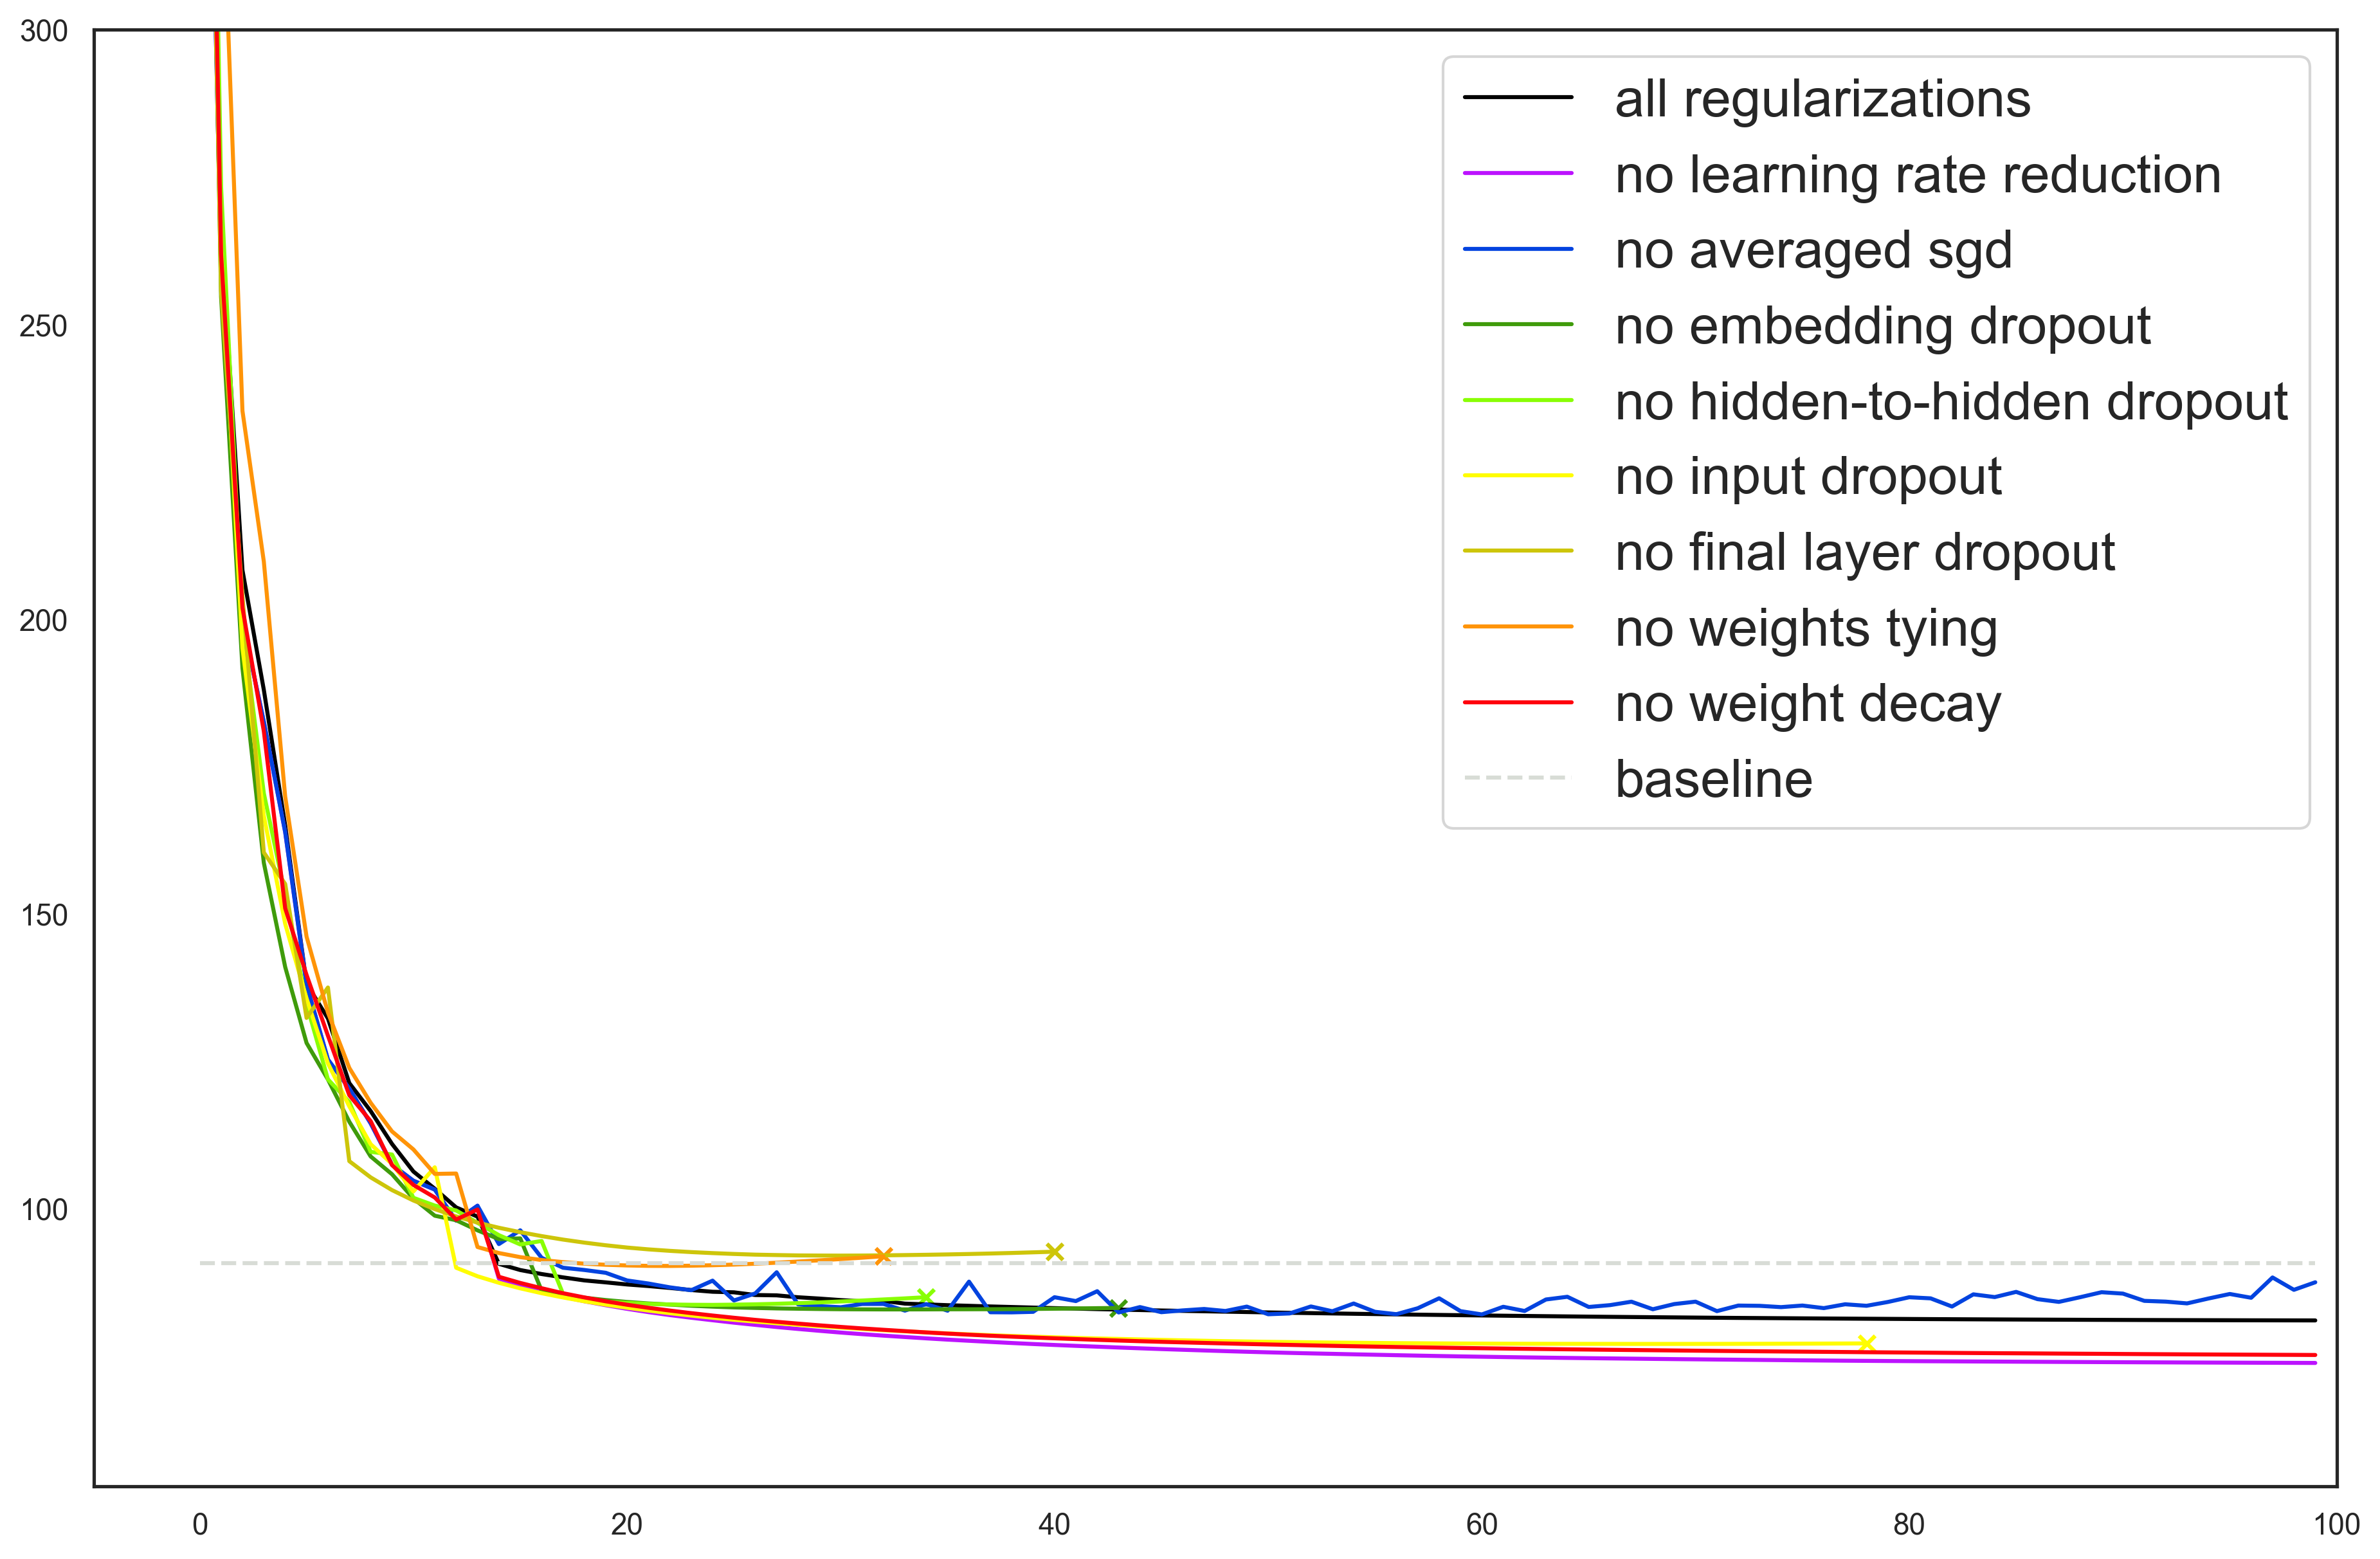

In [21]:
_BASELINE = 90.7
max_len = max(len(results[k]['avg_val_ppls']) for k in results.keys())
sns.set_theme(style='white')
fig, ax = plt.subplots()
for k in results.keys():
    val_ppls = results[k]['avg_val_ppls']
    epochs = range(len(val_ppls))
    ax.plot(epochs, val_ppls, label=to_label[k], color=to_color[k])
    if len(val_ppls) < max_len:
        x = val_ppls[-1]
        y = len(val_ppls)-1
        ax.scatter([y], [x], marker='x', color=to_color[k])
epochs = range(max_len)
baseline = [_BASELINE for _ in epochs]
ax.plot(epochs, baseline, '--', label='baseline', color='xkcd:light grey')
fig.set_figwidth(15)
fig.set_figheight(10)
fig.set_dpi(300)
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.xlim(right=max_len)
plt.ylim(top=300)
plt.legend(loc='upper right')
plt.show()
fig.savefig('data/imgs/comparison_1.png')

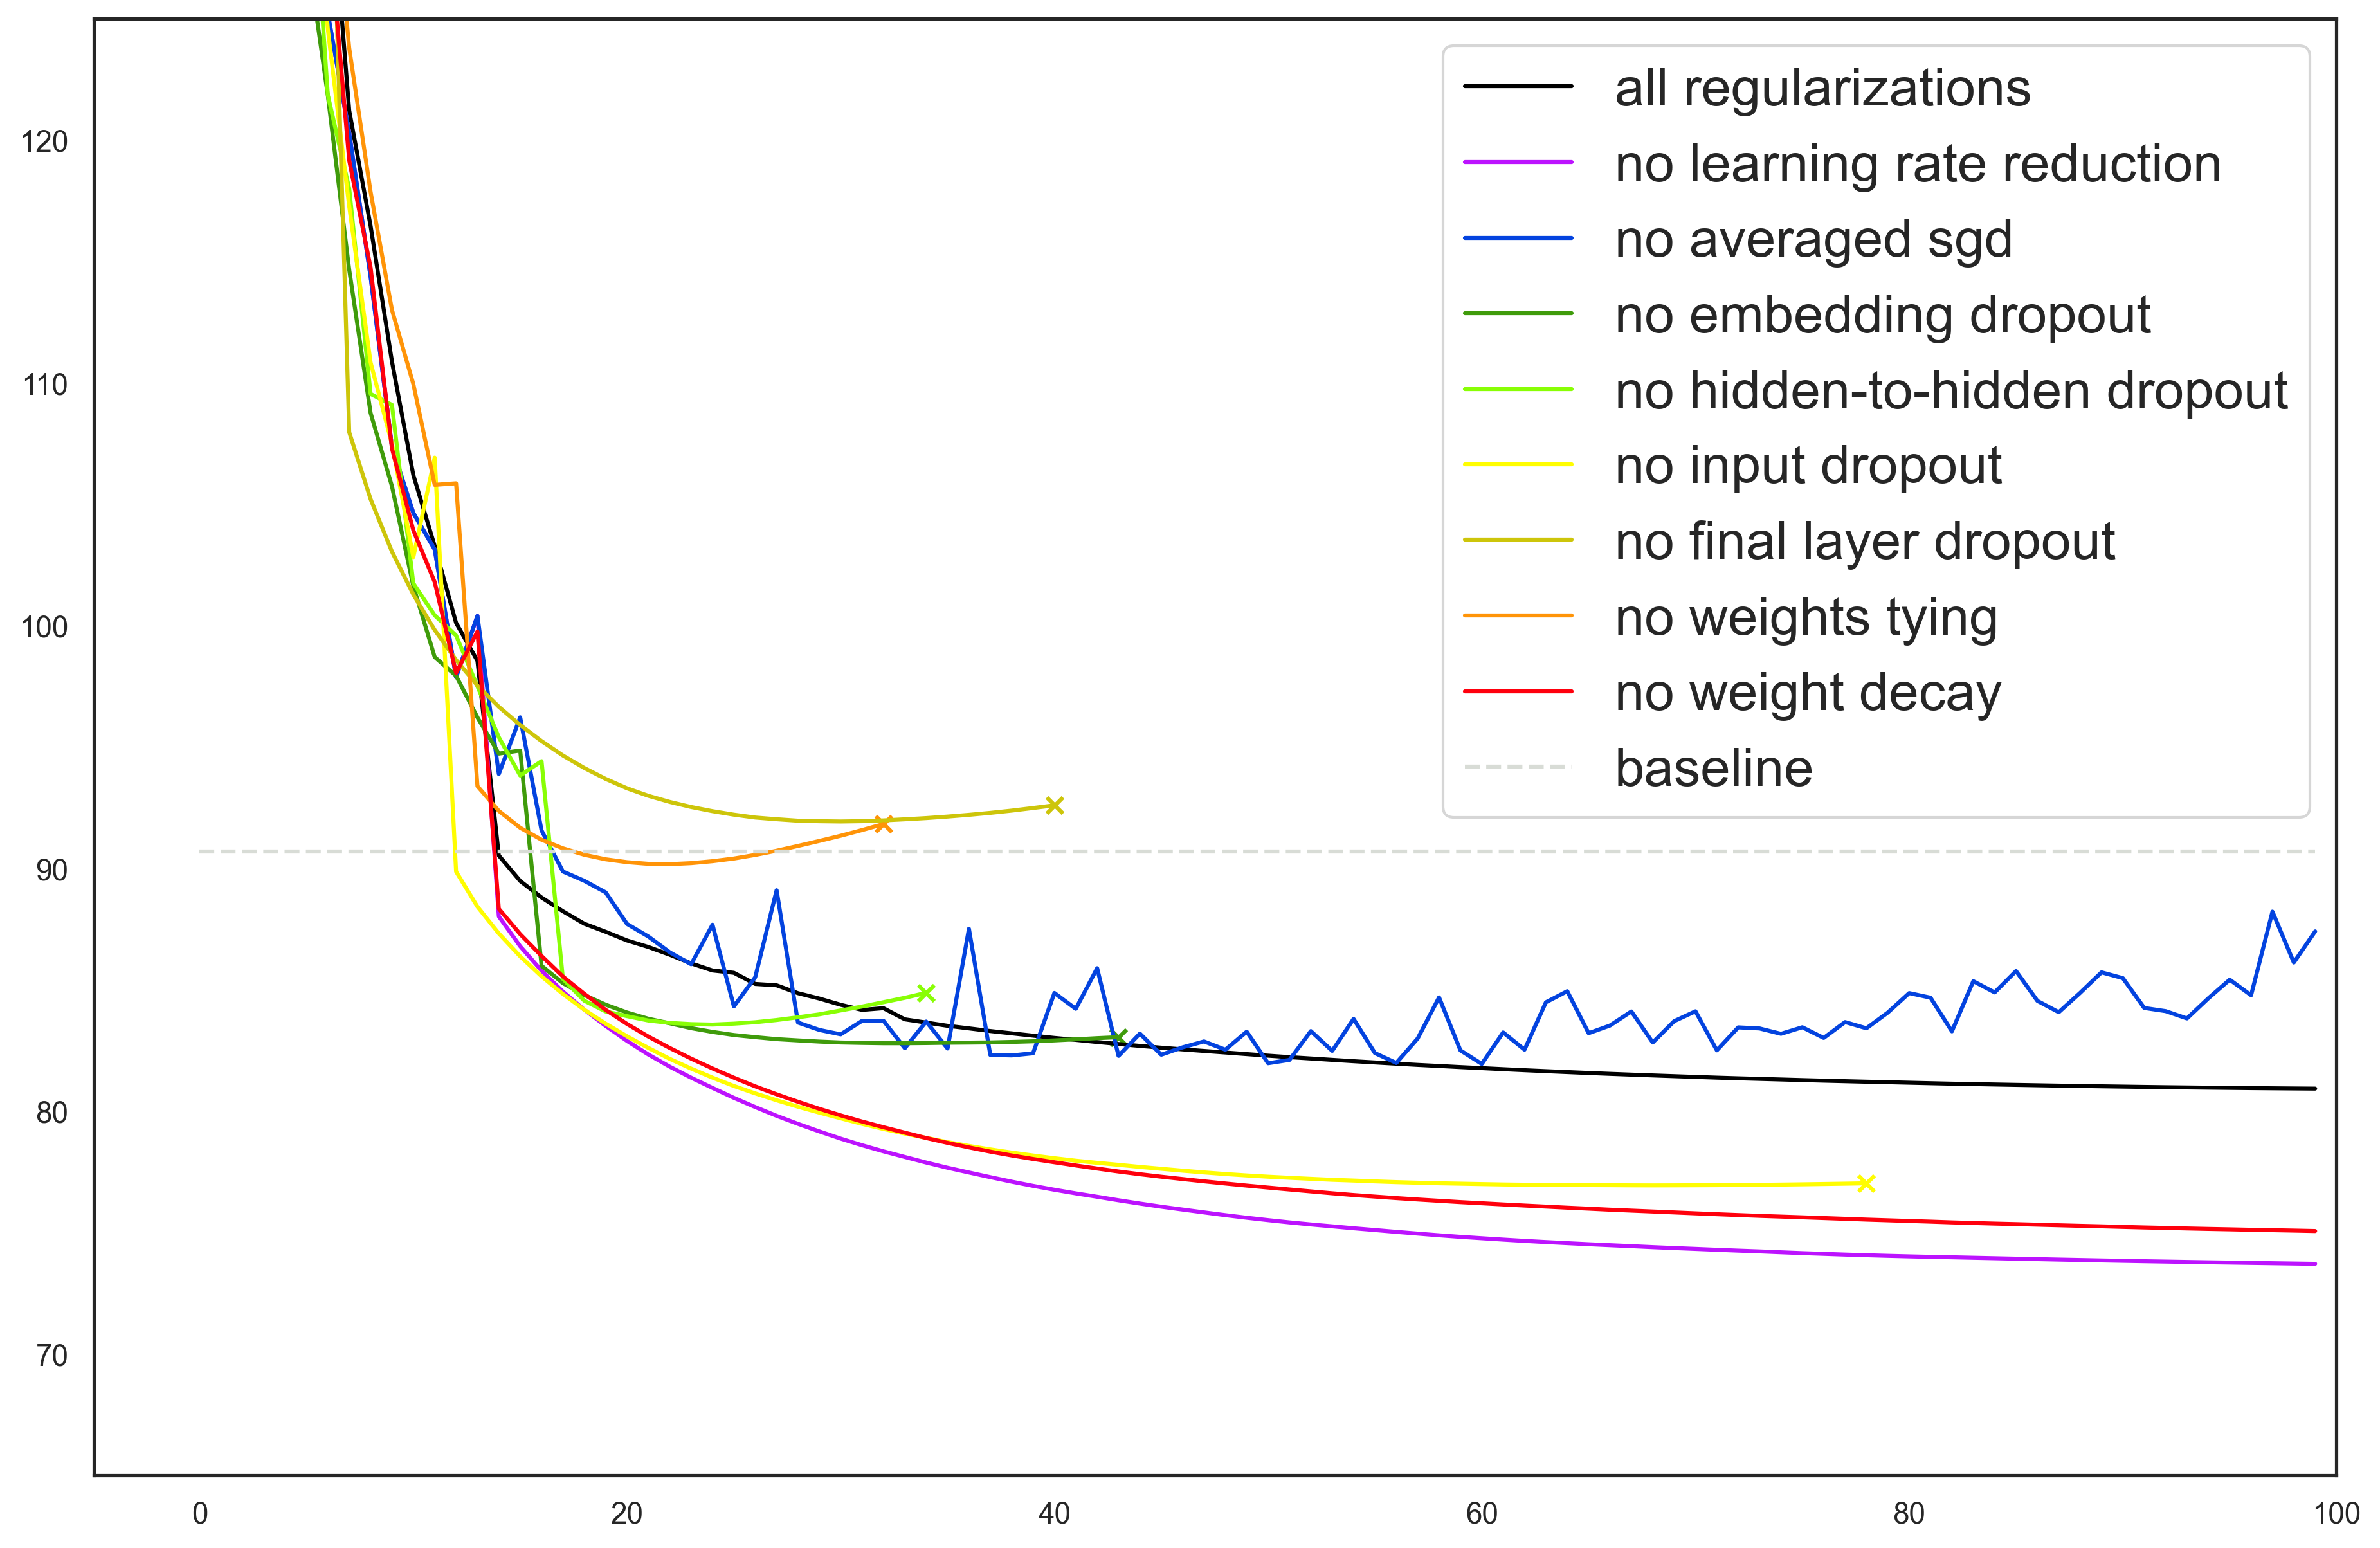

In [18]:
_BASELINE = 90.7
max_len = max(len(results[k]['avg_val_ppls']) for k in results.keys())
sns.set_theme(style='white')
fig, ax = plt.subplots()
for k in results.keys():
    val_ppls = results[k]['avg_val_ppls']
    epochs = range(len(val_ppls))
    ax.plot(epochs, val_ppls, label=to_label[k], color=to_color[k])
    if len(val_ppls) < max_len:
        x = val_ppls[-1]
        y = len(val_ppls)-1
        ax.scatter([y], [x], marker='x', color=to_color[k])
epochs = range(max_len)
baseline = [_BASELINE for _ in epochs]
ax.plot(epochs, baseline, '--', label='baseline', color='xkcd:light grey')
fig.set_figwidth(15)
fig.set_figheight(10)
fig.set_dpi(300)
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.xlim(right=max_len)
plt.ylim(bottom=65, top=125)
plt.legend(loc='upper right')
plt.show()
fig.savefig('data/imgs/comparison_2.png')